FMB example with YCB object mesh, to get visualizations and fmb behavior

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import transforms3d
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import sys
# TODO make fuzzy-ellipses an installable package
root_path = "/home/karen/fuzzy-ellipses"
sys.path.append(root_path)
import utils 


In [4]:
ycb_dir = f"{root_path}/assets/bop/ycbv/train_real"
ycb_dir

'/home/karen/fuzzy-ellipses/assets/bop/ycbv/train_real'

# Pose Estimation

In [5]:
all_data = utils.get_ycbv_data(ycb_dir, 1, [1], fields=[])
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
cam_pose = all_data[0]["camera_pose"]

# mesh data
object_index = 1
mesh = utils.get_ycb_mesh(ycb_dir, all_data[0]["object_types"][object_index])
mesh_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
object_pose = all_data[0]["object_poses"][object_index]
_mesh_vtx = mesh.vertices  # untransformed vertices

# image data
ycb_rgb = all_data[0]["rgb"]
ycb_depth = all_data[0]['depth']
height, width = ycb_rgb.shape[:2]

del all_data

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


In [6]:
# transform and project mesh to rgbd 
mesh_vtx = utils.transform_points(object_pose, _mesh_vtx)

x = np.array(fy * mesh_vtx[:, 1] / mesh_vtx[:, 2] + cy, dtype=np.int32)
y = np.array(fx * mesh_vtx[:, 0] / mesh_vtx[:, 2] + cx, dtype=np.int32)
pixels = np.stack([x, y], axis=1)
rgb = np.zeros((height, width, 3), dtype=np.uint8)
depth = np.zeros((height, width, 1))     

rgb[pixels[:, 0], pixels[:, 1], :] = mesh_colors * 255
depth[pixels[:, 0], pixels[:, 1], 0] = mesh_vtx[:, 2] * 1000 


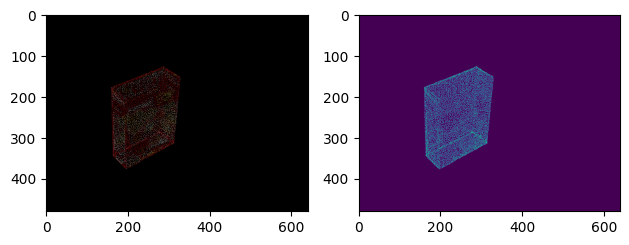

In [7]:
##### adapt setup to FMB repo boilerplate

id_pose = jnp.array([0, 0, 0, 1, 0, 0, 0])

# object data
trans_true = id_pose[:3]
quat_true = id_pose[3:]
shape_scale = 1.0

# image data
image_size = (height, width)
color, target_depth = rgb, depth[..., 0]
# target_depth[target_depth == 0] = np.nan

plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
plt.imshow(target_depth)
plt.tight_layout()

# Setup Fuzzy Metaball renderer

In [8]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
#jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import fm_render

# volume usually False since color optimization implies surface samples
# And code defaults towards that sort of usage now
show_volume = False

NUM_MIXTURE = 40
beta2 = 21.4
beta3 = 2.66

gmm_init_scale = 80

render = fm_render.render_func_quat
render_jit = jax.jit(fm_render.render_func_quat)

In [15]:
# port FMB optimization setup 
import sklearn.mixture
NUM_MIXTURE = 150
pts = mesh_vtx[np.random.randint(0, len(mesh_vtx), NUM_MIXTURE)]
gmm = sklearn.mixture.GaussianMixture(NUM_MIXTURE)
gmm.fit(pts)
weights_log = np.log( gmm.weights_) + np.log(gmm_init_scale)
mean = gmm.means_
prec = gmm.precisions_cholesky_ # cholesky decomposition of the precision matrices of each mixture component. 
                                # a precision matrix is the inverse of the covariance matrix.
                                # (a covariance matrix is symmetric p.d. so the GMM can be parametrized by the precision matrix)

/opt/conda/envs/gen3d/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (148) found smaller than n_clusters (150). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [11]:
prec[0]

array([[ 1.00000000e+03,  9.40255025e-21,  1.12995336e-20],
       [ 0.00000000e+00,  1.00000000e+03, -3.30131907e-20],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+03]])

In [13]:
K = np.array([[fx, 0, cx],[0,fy,cy],[0,0,1]])
pixel_list = (np.array(np.meshgrid(np.arange(width),height-np.arange(height)-1,[0]))[:,:,:,0]).reshape((3,-1)).T
camera_rays = (pixel_list - K[:,2])/np.diag(K)
camera_rays[:,-1] = -1
del pixel_list

In [23]:
est_depth_true, est_alpha_true, _, _ = render_jit(mean,prec,weights_log,camera_rays,quat_true,trans_true,beta2/shape_scale,beta3)

In [24]:
vmin,vmax = np.nanmin(target_depth),np.nanmax(target_depth)
vmin, vmax

(0.0, 1206.6927970683719)

In [18]:
mean = jnp.array([0.0, 0.0, 1.0])
weights_log = jnp.log(jnp.array([1.0]))

est_depth_true, est_alpha_true, _, _ = render_jit(mean,prec[0],weights_log,camera_rays,quat_true,trans_true,beta2/shape_scale,beta3)

quat: (4,), t: (3,). camera_rays: (307200, 3), camera_starts_rays: (307200, 2, 3)
means: (3,), prec_full: (3, 3), weights_log: (1,), camera_starts_rays: (307200, 2, 3), beta_2: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, beta_3: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 3, e.g. axis 0 of argument prcI of type float32[3,3];
  * one axis had size 1: axis 0 of argument w of type float32[1]

(-0.5, 639.5, 479.5, -0.5)

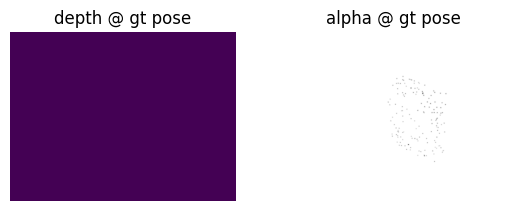

In [27]:
# plt.subplot(2,3,1)
# plt.imshow(color)
# plt.title('image')
# plt.axis('off')

plt.subplot(1,2,1)
_est_depth_true = np.array(est_depth_true)
plt.imshow(_est_depth_true.reshape(image_size),vmin=vmin,vmax=vmax)
plt.title('depth @ gt pose')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(est_alpha_true.reshape(image_size),cmap='Greys')
plt.title('alpha @ gt pose')
plt.axis('off')
